# Creating NLP Datasets with Custom Identities

To detect bias in NLP based on identity terms, the dataset must include labels classifying the identities present in the dataset. This google colab allows users to: 

1.   Customize the identities to search for
2.   Download a dataset and label the identities found
2.   Expand a custom or existing dataset with more datapoints of any identities specified, by duplicating texts and changing the identity terms.

The result of this google colab is automated dataset creation to remove restrictions on anaylzing datasets for bias when the dataset is unlabeled or too small.





# Prepare the Dataset

Download the dataset, add labels, and extract the test set.

In [ ]:
#import libraries
!pip install datasets
from datasets import load_dataset 
import pandas as pd


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

def dataset_import(dataset_name):
  full_df = load_dataset(dataset_name)
  print(full_df)
  return full_df

def local_import(dataset_name):
  df = pd.read_csv(dataset_name)
  df.head()
  return df


full_df = dataset_import("ag_news")

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [ ]:
#take the test set of the dataset
full_df.set_format(type="pandas")
df = full_df["test"][:]
df.head()

,text,label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3


In [ ]:
#add column with label names
def label_int2str(row):
    return full_df["test"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,Fears for T N pension after talks Unions repre...,2,Business
1,The Race is On: Second Private Team Sets Launc...,3,Sci/Tech
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3,Sci/Tech
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3,Sci/Tech
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3,Sci/Tech


# Analyze the Dataset

What is the distribution of categories? Do certain categories tend to have more words than others?

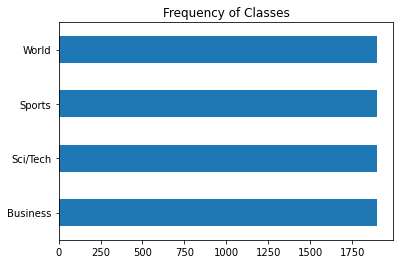

In [ ]:
#Have a look at the distribution of classifications
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

As this is an NLP dataset, the lengths of texts can impact the models perdiciton, so if the distribution is uneven, you may consider parsing the dataset into different size categories.


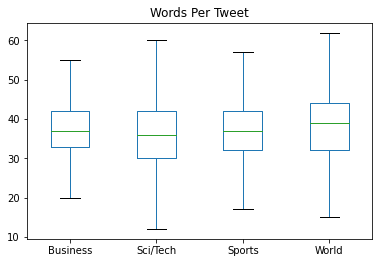

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, 
           showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

# Identities
This section includes a dictionary of categories of identities (gender, sexual orientation, religion, etc...), and within each category it has groups. For example the Gender category has a male, female and transgender group. Each group is represented by a dictionary which has terms that this colab notebook will search for to identify the respective group.

Users can add or remove to this dictionary as they'd like, no edits need to be made to future cells as long as this structure is followed.

This dictionary of identities was inspired by the paper "Nuanced Metrics for Measuring Unintended Bias with Real Data for Text Classification"

Please note, capitalization doesn't matter, however suffixes, hyphens, and special characters do.

If a word typically contains a hyphen or special character, please include both version of the word (e.g. Baha'i and Bahá’í or non-conforming and non conforming).

Please keep in mind slang, different suffixes, and short forms for words.

The algorithm will scan for exactly the terms that are inputted into the dictionary.

In [ ]:

Extended_Identities = {"Gender" : {"Male" : ["Male", "Men", "Man"],\
                                  "Female" : ["Female", "Women", "Woman"],\
                                  "Transgender" : ["Transgender", "Trans"],\
                                  "Other Genders": ["Intersex", "Non-Conforming","Non Conforming", "Agender", "Bigender", "Cisgender","Gender Fluid", "Genderqueer", "Mx", "Gender Neutral", "Non-Binary", "Non Binary", "agender", "pangender"]},\
              "Sexual Orientation" : {"Heterosexual" : ["Heterosexual","Straight"],\
                                      "Homosexual" : ["Homosexual", "Gay", "Lesbian"],\
                                      "Bisexual": ["Bisexual"],\
                                      "Other Sexual Orientations" : ["Asexual"]},\
              "Religion" : {"Christian" : ["Christian", "Christianity"],\
                            "Jewish" : ["Jewish", "Judaism"],\
                            "Muslim" : ["Muslim", "Islam"],\
                            "Hindu": ["Hindu", "Hinduism"],\
                            "Buddhist" : ["Buddhist","Buddhism"],\
                            "Atheist" : ["Atheist", "Atheism"],\
                            "Other Religions" : ["Agnosticism" "Baha'i", "Bahá’í", "Confucianism", "Jainism", "Shinto", "Sikhism", "Taoism", "Zoroastrianism", "Druze", "Gnosticism", "Rastafarianism", "Traditional African Religions", "African Diaspora Religions", "Indigenous American Religions"]},
              "Race/Ethnicity" : {"Black" : ["Black", "African", "African American"],\
                                  "White" : ["White", "Caucasian", "European"],\
                                  "Asian" : ["Asian", "Chinese", "Indian", "Japanese", "Korean"],\
                                  "Latino" : ["Latino", "Latina", "Latinx"],\
                                  "Other Races" : ["Indigenous","Alaska Native", "American Indian", "Native"]}, \
              "Disability" : {"Physical disability" : ["Physical disability"],\
                              "Intellectual disability" : ["Intellectual disability", "learning disability", "autism", "spectrum disorder", "dyslexia", "dyslexic"],\
                              "Mental Illness" : ["Mental Illness", "Mentally Ill", "Psychiatric disability", "mental health"],\
                              "Other Disabilities" : ["vision Impairment", "deaf", "hard of hearing", "brain injury"]}}


# Add Identity Labels to Dataset

Add columsn for each identity category defined in the Extended_Identities dictionary, and add labels for each identity group found.

In [ ]:
#inport libraries for data parsing. The LwrStpIntraAnalyzer will filter out unwanted punctuation, capitalization, and more
import nltk
from nltk.stem import *
import string
import numpy as np

!pip install whoosh

from whoosh import index, writing
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED
from whoosh.analysis import *
from whoosh.qparser import QueryParser

LwrStpIntraAnalyzer = RegexTokenizer() | LowercaseFilter() | IntraWordFilter() | StopFilter()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Add columns for each category
for category in Extended_Identities.keys():
  df[category] = np.nan

df.head()

,text,label,label_name,Words Per Tweet,Gender,Sexual Orientation,Religion,Race/Ethnicity,Disability
0,Fears for T N pension after talks Unions repre...,2,Business,25,NaN,NaN,NaN,NaN,NaN
1,The Race is On: Second Private Team Sets Launc...,3,Sci/Tech,48,NaN,NaN,NaN,NaN,NaN
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3,Sci/Tech,45,NaN,NaN,NaN,NaN,NaN
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3,Sci/Tech,55,NaN,NaN,NaN,NaN,NaN
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3,Sci/Tech,34,NaN,NaN,NaN,NaN,NaN


In [ ]:
words_found = set() #keep track of words found in the dataset
for category in Extended_Identities.keys():
  for index in range(df.shape[0]):
    text = df["text"][index]
    found_indentity = 0
    for group in Extended_Identities[category]:

      temp = [token.text for token in LwrStpIntraAnalyzer(text)]
      indentity_terms = [x.lower() for x in Extended_Identities[category][group]]
      for token in temp:
        if token in indentity_terms:
          words_found.add(token)
          if found_indentity == 1:
            existing_groups_found = df[category][index]
            groups = existing_groups_found + " " + group
            df[category][index] = groups
          else:
            df[category][index] = group
            found_indentity = 1
          break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Lets take a look at the kind of words found in the dataset

In [ ]:
words_found

{'african',
 'asian',
 'black',
 'buddhist',
 'chinese',
 'christian',
 'christianity',
 'european',
 'female',
 'gay',
 'indian',
 'indigenous',
 'islam',
 'japanese',
 'jewish',
 'korean',
 'male',
 'man',
 'men',
 'muslim',
 'native',
 'straight',
 'trans',
 'white',
 'woman',
 'women'}

This is what the labeled dataset looks like, however you might not see any identities found in the first 5 rows

In [ ]:
df.head(5)

,text,label,label_name,Words Per Tweet,Gender,Sexual Orientation,Religion,Race/Ethnicity,Disability
0,Fears for T N pension after talks Unions repre...,2,Business,25,NaN,NaN,NaN,NaN,NaN
1,The Race is On: Second Private Team Sets Launc...,3,Sci/Tech,48,NaN,NaN,NaN,NaN,NaN
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3,Sci/Tech,45,NaN,NaN,NaN,NaN,NaN
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3,Sci/Tech,55,NaN,NaN,NaN,NaN,NaN
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3,Sci/Tech,34,NaN,NaN,NaN,NaN,NaN


Lets create a dictionary of only texts that contained at least one identity term

In [ ]:
identities_df = df.dropna(how = 'all',subset=list(Extended_Identities.keys()))
identities_df.head(20)

,text,label,label_name,Words Per Tweet,Gender,Sexual Orientation,Religion,Race/Ethnicity,Disability
17,Mars Rovers Relay Images Through Mars Express ...,3,Sci/Tech,52,NaN,NaN,NaN,White,NaN
32,Sister of man who died in Vancouver police cus...,0,World,44,Male,NaN,NaN,NaN,NaN
33,"Man Sought #36;50M From McGreevey, Aides Say ...",0,World,52,Male,Homosexual,NaN,NaN,NaN
43,Spam suspension hits Sohu.com shares (FT.com) ...,3,Sci/Tech,47,NaN,NaN,NaN,Asian,NaN
48,China Says Taiwan Spy Also Operated in U.S. - ...,0,World,42,NaN,NaN,NaN,Asian,NaN
50,US fighter squadron to be deployed in South Ko...,0,World,47,NaN,NaN,NaN,Asian,NaN
56,India's Tata expands regional footprint via Na...,0,World,41,NaN,NaN,NaN,Asian,NaN
62,Natalie Coughlin Wins 100M Backstroke (AP) AP ...,1,Sports,64,Female,NaN,NaN,NaN,NaN
65,Indian state rolls out wireless broadband Gove...,3,Sci/Tech,25,NaN,NaN,NaN,Asian,NaN
69,"Suspect charged in abduction, sexual assault o...",0,World,41,Male,NaN,NaN,NaN,NaN


One feature of this algorithm, is that it will add labels if multiple groups per category is found. For example, if a sentence includes "man" and "female", the label will become "Male Female". Lets take a look at one of these examples directly from the dataset.

In [ ]:
male_and_female_examples = pd.DataFrame.to_csv(identities_df.loc[df['Gender'] == 'Male Female'][:1]['text'])
print(male_and_female_examples)


,text
364,"Three People Killed at Afghan Checkpoint  KABUL (Reuters) - A man and two women were shot dead by  Afghan and U.S.-led troops after their vehicle ran through a  checkpoint on Saturday, a U.S. military statement said."



Lets have a look at the distribution of classes now that only terms including identities were kept.

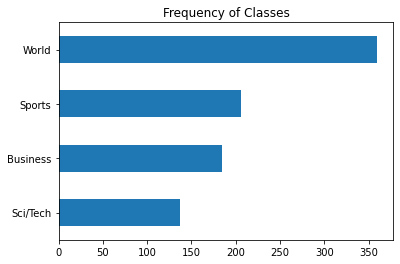

In [ ]:
identities_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Lets compile a figure of plots with the total distribution breakdown: by categories and groups.

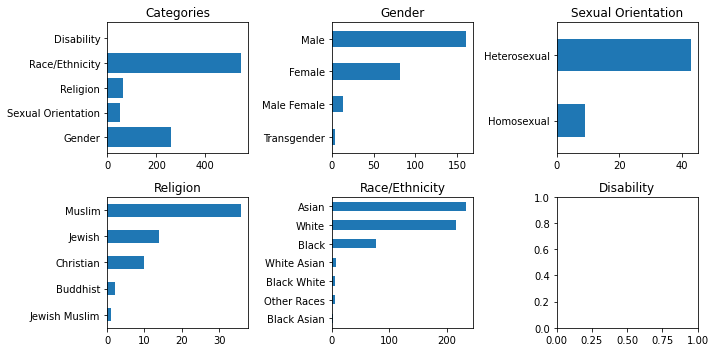

In [ ]:
def plot_distributions(plot_df):
  #Fill out subplot dimensions
  categories = []
  category_counts = []
  for category in Extended_Identities.keys():
    categories.append(category)
    category_counts.append(plot_df[category].count())

  x_dim = 3
  y_dim = int(len(Extended_Identities)/x_dim) + 1
  subplot_ind = 1

  # fig = plt.figure()
  fig, axs = plt.subplots(y_dim, x_dim, figsize=(10, 5))

  #First plot
  plt.subplot(y_dim, x_dim, subplot_ind)
  plt.barh(categories, category_counts)
  plt.title("Categories")

  for category in Extended_Identities.keys():
    subplot_ind += 1
    plt.subplot(y_dim, x_dim, subplot_ind)
    if plot_df[category].count() > 0:
      plot_df[category].value_counts(ascending=True).plot.barh()
    plt.title(category)

  plt.tight_layout()

plot_distributions(identities_df)

There may be empty plots, which means none of the terms specified in that category were found in the dataset.

Download the dataset into a csv to have a closer look at it

In [ ]:

def download_dataset(dataset, dataset_name):
  file_name = '{fname}.csv'.format(fname = dataset_name)
  compression_opts = dict(method='zip',
                          archive_name=file_name)
  zip_name = '{fname}.zip'.format(fname = dataset_name)
  dataset.to_csv(zip_name, index=False,
            compression=compression_opts)  
  
download_dataset(identities_df, "Identities_Df")

# Input Template Dataset

In this section, take time to look at the dataset outputted by the previous steps. Ensure the quality of the dataset you are going to imput as the "template dataset" (meaning the texts given will be duplicated and identities terms will be replaced with terms from different identity groups). You can delete examples you think are irrelevant, add examples, or create your own tempalte dataset.


              


To create your own template dataset, either create a csv with texts and classification but no identitification labels and input it at the top of the colab notebook, or import the csv with classifications and identification labels (that match the order of the Extended_Identifications dictionaries) and proceed.

If you want to create your own templates (e.g. The ____ scientist won a Nobel prize in 1988), insert a term within the identity category you want to have variations from.

e.g. lets assume you are only looking at male and female gender bias

Your Exetended_Identities is as follows:


Extended_Identities = {"Gender" : {"Male" : ["Male", "Men", "Man"], "Female" : ["Female", "Women", "Woman"]}}

You want the sentence 

"The ____ scientist won a Nobel prize in 1988" 

to have a version with the Male label and a version with the Female label. Simply replace the ___ with a term from that category, and the algorithm will find it can replace it with a term from the other group within the gender category. In this example the input and output will be as follows:

**Input:**
(csv)

Text, Label     

"The male scientist won a Nobel prize in 1988", 1

"The shocking income of professional female football stars", 0

**Output:**
(csv)

Text, Label, Gender

"The male scientist won a Nobel prize in 1988", 1, "Male"

"The female scientist won a Nobel prize in 1988", 1, "Female"

"The shocking income of professional female football stars", 0, "Female"

"The shocking income of professional male football stars", 0, "Male"

In [ ]:
identities_df = identities_df #replace this with an import statement if needed

# Generate Expanded Identities Dataset

In [ ]:
#this function picks the term from the identity group. It selects randomly
#this function could be replaced with a direct mapping of terms e.g. Male -> Female, Man -> Woman
#however the if your NLP model uses a word representation model like BERT or Glove, the mapping of woman vs female will be very similar
def random_choice(Identities_less_real_group, new_group):
  return random.choice(Identities_less_real_group[new_group]).lower()

columns = list(identities_df.columns)

import random
new_entries = []

for row in identities_df.iterrows():
  index = row[0]
  for category in Extended_Identities.keys():

    if not pd.isnull(identities_df[category][index]):
      group = identities_df[category][index]

      adding_entry = row[1].copy()
      if group in Extended_Identities[category]:
        # this algorithm only duplicate terms with one group identitfied per category
        new_entries.append(adding_entry.copy())
        text = row[1]["text"].lower()
        indentity_terms = [x.lower() for x in Extended_Identities[category][group]]
        Identities_less_real_group = Extended_Identities[category].copy()
        del Identities_less_real_group[group]

        for new_group in list(Identities_less_real_group.keys()):
          new_term = random_choice(Identities_less_real_group, new_group)
          new_text = text
          for search_group in indentity_terms:
            new_text = new_text.replace(search_group, new_term)
          adding_entry[category] = new_group
          adding_entry['text'] = new_text
          new_entries.append(adding_entry.copy())

new_df = pd.DataFrame(new_entries)


Compare the lengths of your datasets

In [ ]:
old_len = len(identities_df)
new_len = len(new_df)
print("The identifies_df dataset contains: ",old_len," datapoints")
print("The new_df dataset contains: ",new_len," datapoints")
percent_increase = "{:.2f}%".format((new_len-old_len)*100/old_len)
print("The dataset has increased by ", percent_increase)



The identifies_df dataset contains:  888  datapoints
The new_df dataset contains:  4295  datapoints
The dataset has increased by  383.67%


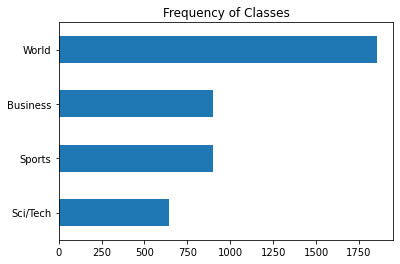

In [ ]:
new_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Download your dataset into csv format, to save, and input into your NLP model

In [ ]:
download_dataset(new_df, "Expanded_Identities_Dataset")